# TM10007 Machine Learning Assignment 2021
Linda Chen (4648242), Yaro Roodenburg (4553322), Laurent Coopmans (4672577) & Killian Zijlstra (4652460)

In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [5]:
# import all packages
import os
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn import model_selection
from skimage import data
from adni.load_data import load_data
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
import itertools as it
import seaborn

# Classifiers
#from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Feature selection
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix


In [14]:
# Used function, from exercises from the course
def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Function to count frequency. Courtesy of:
# https://www.geeksforgeeks.org/counting-the-frequencies-in-a-list-using-dictionary-in-python/
def CountFrequency(my_list):
      
    # Creating an empty dictionary 
    freq = {}
    for items in my_list:
        freq[items] = my_list.count(items)
      
    for key, value in freq.items():
        print ("% d : % d"%(key, value))

In [6]:
# Data loading functions
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

df_AD = data[data['label'] == 'AD']
print(f'The number of samples with AD: {len(df_AD.index)}')

df_CN = data[data['label'] == 'CN']
print(f'The number of samples with no AD: {len(df_CN.index)}')

features = data.columns.tolist()
labels = data['label'].tolist()

# Split the dataset in train and test part
# X_train, X_test, y_train, y_test = train_test_split(data[features],
#                                                     labels,
#                                                     test_size=0.2,
#                                                     stratify=labels,
#                                                     random_state=8)
# df = X_train
# df_test = X_test
# print(type(data))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\yaro1\\miniconda3\\lib\\site-packages\\adni\\ADNI_radiomicFeatures.csv'

In [16]:
# five time stratified random feature elimination
skf = StratifiedKFold(n_splits=5, random_state=42)
labels_binary = [1 if label == 'CN' else 0 for label in labels]
chosen_features = []

for X_train, X_test in skf.split(data[features], labels_binary):
  df = data.iloc[X_train]
  df_test = data.iloc[X_test]

  labels = df['label'].tolist()
  df_AD = df[df['label'] == 'AD']
  print(f'The number of samples with AD: {len(df_AD.index)}')

  df_CN = df_test[df_test['label'] == 'CN']
  print(f'The number of samples with no AD: {len(df_CN.index)}')

  # First, remove the label column as that cannot be scaled
  df_drop = df.drop(['label'], axis=1)
  df_AD_scaled = df_AD.drop(['label'], axis=1)
  df_CN_scaled = df_CN.drop(['label'], axis=1)
  X_test_scaled = df_test.drop(['label'], axis=1)
  scaler = preprocessing.MinMaxScaler()
  scaler.fit(df_drop)
  df_scaled = scaler.transform(df_drop)
  df_AD_scaled = scaler.transform(df_AD_scaled)
  df_CN_scaled = scaler.transform(df_CN_scaled)
  X_test_scaled = scaler.transform(X_test_scaled)

  # transform back to dataframes
  df_scaled = pd.DataFrame(df_scaled)
  df_AD_scaled = pd.DataFrame(df_AD_scaled)
  df_CN_scaled = pd.DataFrame(df_CN_scaled)
  X_test_scaled = pd.DataFrame(X_test_scaled)

  # extract all feature names
  features = df.columns.tolist()
  features.remove('label')

  df_scaled.columns = features
  df_AD_scaled.columns = features
  df_CN_scaled.columns = features
  X_test_scaled.columns = features

  # Implement Mann whitney u test
  p_values = list()

  for feature in features:
      # extract values form column of dataframe
      values_AD = df_AD_scaled[feature].values.tolist()
      values_CN = df_CN_scaled[feature].values.tolist()

      if values_AD[0:50] == values_CN[0:50]:
          continue
      else:
          # mann whitney u test
          statistic, p_value = sp.stats.mannwhitneyu(values_AD,
                                                     values_CN,
                                                     use_continuity=True,
                                                     alternative=None)
          p_values.append(p_value)

  # create dict from p_values and features
  dict_p_values = dict(zip(features, p_values))

  # Bonferroni correction
  Bonferroni_corrected_p_values = {key:val for key, val in dict_p_values.items() if val < 0.05/len(p_values)}

  # Create new DataFrame with only the significant features
  df_sig_ft = df_scaled[Bonferroni_corrected_p_values.keys()]
  df_sig_ft_test = X_test_scaled[Bonferroni_corrected_p_values.keys()]

  # Create new list with labels for the selected features
  # Separate labels AD from CN
  labels = df['label'].tolist()
  labels_test = df_test['label'].tolist()
  labels_bin = [1 if label == 'CN' else 0 for label in labels]
  labels_bin_test = [1 if label == 'CN' else 0 for label in labels_test]

  # Convert dataframe to numpy array
  arr_sig_ft = df_sig_ft.to_numpy()

  # Greedy feature selection
  # Create pipeline
  estimator = SVC(kernel="linear", max_iter=5000)
  rfecv = RFECV(estimator, step=1)
  model = SVC(kernel="linear", max_iter=5000)
  pipeline = Pipeline(steps=[('s', rfecv), ('m', model)])
  # Evaluate model
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0)
  n_scores = cross_val_score(pipeline,
                            arr_sig_ft,
                            labels_bin,
                            scoring='accuracy',
                            cv=cv,
                            n_jobs=-1,
                            error_score='raise')
  # Report performance
  print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

  # Report which features were selected by RFE
  # Fit RFECV
  rfecv.fit(arr_sig_ft, labels_bin)
  # Summarize all features
  for i in range(arr_sig_ft.shape[1]):
      print('Column: %d, Selected %s, Rank: %.3f' % (i,
                                                    rfecv.support_[i],
                                                    rfecv.ranking_[i]))
      
  # Select features with ranking 1.000 (relative ranking of importance)
  # First, find their indices
  feat_loc = np.where(rfecv.ranking_ == 1.000)
  feat_select = df_sig_ft.columns[feat_loc]
  feat_select_list = feat_select.values.tolist()
  chosen_features.extend(feat_select_list)


The number of samples with AD: 415
The number of samples with no AD: 67


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy: 0.820 (0.053)
Column: 0, Selected True, Rank: 1.000
Column: 1, Selected False, Rank: 7.000
Column: 2, Selected False, Rank: 29.000
Column: 3, Selected False, Rank: 48.000
Column: 4, Selected False, Rank: 4.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected False, Rank: 50.000
Column: 8, Selected False, Rank: 93.000
Column: 9, Selected False, Rank: 97.000
Column: 10, Selected False, Rank: 69.000
Column: 11, Selected False, Rank: 47.000
Column: 12, Selected False, Rank: 46.000
Column: 13, Selected False, Rank: 66.000
Column: 14, Selected False, Rank: 76.000
Column: 15, Selected False, Rank: 65.000
Column: 16, Selected False, Rank: 62.000
Column: 17, Selected False, Rank: 95.000
Column: 18, Selected False, Rank: 91.000
Column: 19, Selected False, Rank: 57.000
Column: 20, Selected False, Rank: 43.000
Column: 21, Selected False, Rank: 73.000
Column: 22, Selected False, Rank: 5.000
Column: 23, Selected False, Rank: 61.000
Column: 24,

In [ ]:
# Now, only select the features that were chosen in 2 folds or more to ensure stability
unique_features = list(set(chosen_features))
freq_features = [chosen_features.count(f) for f in unique_features]
dict_features = dict(zip(unique_features, freq_features))
dict_features = {k: v for k,v in dict_features.items() if v > 2}
print(f'Number of features chosen: {len(dict_features)}')

In [18]:
# From all selected features, only select the features that were chosen in 
# 2 folds or more to ensure stability and generalizability
unique_features = list(set(chosen_features))
freq_features = [chosen_features.count(f) for f in unique_features]
dict_features = dict(zip(unique_features, freq_features))
dict_features = {k: v for k,v in dict_features.items() if v > 2}
print(f'Number of features chosen: {len(dict_features)}')

# Now, take the features from the dictionary and 
# select the right columns from the dataframe
final_features = list(dict_features.keys())

# Then select the right columns
df_select = df_sig_ft[final_features]
print(df_select.columns)

# Also, select the features in the test dataset
X_test_select = df_sig_ft_test[final_features]
print(X_test_select)

# Convert dataframes and lists to numpy arrays
arr_select = df_select.to_numpy()
array_test_select = X_test_select.to_numpy()
labels_bin = np.array(labels_bin)
labels_bin_test = np.array(labels_bin_test)

Number of features chosen: 13
Index(['hf_quartile_range', 'tf_Gabor_0.5A0.0min', 'tf_LBP_skew_R8_P24',
       'tf_Gabor_0.05A0.0std', 'tf_Gabor_0.05A0.0skew', 'tf_Gabor_0.05A0.0min',
       'tf_GLSZM_GrayLevelNonUniformity', 'tf_Gabor_0.05A0.79mean',
       'hf_entropy', 'hf_peak', 'tf_Gabor_0.05A2.36min', 'tf_LBP_std_R3_P12',
       'tf_Gabor_0.2A0.79min'],
      dtype='object')
     hf_quartile_range  ...  tf_Gabor_0.2A0.79min
0             0.708486  ...              0.640587
1             0.716360  ...              0.709755
2             0.294083  ...              0.581258
3             0.105598  ...              0.832698
4             0.258481  ...              0.770761
..                 ...  ...                   ...
166           0.096957  ...              0.697784
167           0.234038  ...              0.640300
168           0.116245  ...              0.579254
169           0.500093  ...              0.523838
170           0.081010  ...              0.707345

[171 rows x 13 c

In [ ]:
# Visualize the features in scatter plots
feat_comb = list(it.combinations(final_features, 2))
for features in feat_comb:
    plt.figure()
    seaborn.scatterplot(x=features[0],
                        y=features[1],
                        hue=labels_bin,
                        data=df_select)

In [20]:
# Train classifier

# Create empty lists to save the scores and chosen hyperparameters in
scores_val = []
scores_train = []
f1_scores_train = []
f1_scores_val = []

C_select = []
gamma_select = []
kernel_select = []

for train, val in skf.split(arr_select, labels_bin):
    print('train -  {}   |   val -  {}'.format(np.bincount(labels_bin[train]),
                                               np.bincount(labels_bin[val])))
    svm_clf = svm.SVC(probability=True, random_state=42)
    params_tuning = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
    clf = RandomizedSearchCV(svm_clf, params_tuning)
    clf.fit(arr_select[train], labels_bin[train])
    y_pred_train = clf.predict(arr_select[train])
    y_pred_val = clf.predict(arr_select[val])

    scores_val.append(clf.score(arr_select[val], labels_bin[val]))
    scores_train.append(clf.score(arr_select[train], labels_bin[train]))
    C_select.append(clf.best_estimator_.C)
    gamma_select.append(clf.best_estimator_.gamma)
    kernel_select.append(clf.best_estimator_.kernel)
    f1_scores_train.append(metrics.f1_score(y_pred_train, labels_bin[train]))
    f1_scores_val.append(metrics.f1_score(y_pred_val, labels_bin[val]))

    print(f'Classifier score training set: {clf.score(arr_select[train], labels_bin[train])}')
    print(f'Classifier score validation set: {clf.score(arr_select[val], labels_bin[val])}')
    print(f'F1-score training set: {metrics.f1_score(y_pred_train, labels_bin[train])}')
    print(f'F1-score validation set: {metrics.f1_score(y_pred_val, labels_bin[val])}')

mean_scores_val = np.mean(scores_val)
mean_scores_train = np.mean(scores_train)
mean_f1_train = np.mean(f1_scores_train)
mean_f1_val = np.mean(f1_scores_val)
print(f'Mean scores training set: {mean_scores_train}')
print(f'Mean score validation set: {mean_scores_val}')
print(f'Mean f1 score training set: {mean_f1_train}')
print(f'Mean f1 score validation set: {mean_f1_val}')

train -  [332 215]   |   val -  [84 53]
Classifier score training set: 0.8318098720292505
Classifier score validation set: 0.8613138686131386
F1-score training set: 0.7722772277227723
F1-score validation set: 0.8256880733944955
train -  [333 214]   |   val -  [83 54]
Classifier score training set: 0.8482632541133455
Classifier score validation set: 0.7956204379562044
F1-score training set: 0.7970660146699265
F1-score validation set: 0.7254901960784315
train -  [333 214]   |   val -  [83 54]
Classifier score training set: 0.8409506398537477
Classifier score validation set: 0.8102189781021898
F1-score training set: 0.7841191066997518
F1-score validation set: 0.723404255319149
train -  [333 214]   |   val -  [83 54]
Classifier score training set: 0.829981718464351
Classifier score validation set: 0.8613138686131386
F1-score training set: 0.7759036144578313
F1-score validation set: 0.8190476190476189
train -  [333 215]   |   val -  [83 53]
Classifier score training set: 0.8357664233576643


In [ ]:
# Now create a classifier with the right hyperparameters
# Majority voting was used in order to choose the final hyperparameters
C_final = max(set(C_select), key=C_select.count)
kernel_final = max(set(kernel_select), key=kernel_select.count)
gamma_final = max(set(gamma_select), key=gamma_select.count)
params_final = {'C': C_final, 'gamma': gamma_final, 'kernel': kernel_final}
print(f'The final value for C is: {C_final}')
print(f'The final kernel is: {kernel_final}')
print(f'The final value for gamma is: {gamma_final}')

# Implement these hyperparameters and train a new classifier
# using the entire training set
clf_test = svm.SVC(random_state=42,
                   gamma=gamma_final,
                   C=C_final,
                   kernel=kernel_final)
clf_test.fit(arr_select, labels_bin)

# Finally, apply the classifier to the test set and
# compute the accuracy and F1-score
accuracy_test = clf_test.score(array_test_select, labels_bin_test)
print(f'The accuracy on the test set is {accuracy_test}')
y_pred = clf_test.predict(array_test_select)
f1_score_test = metrics.f1_score(y_pred, labels_bin_test)
print(f'The f1-score on the test set is {f1_score_test}')

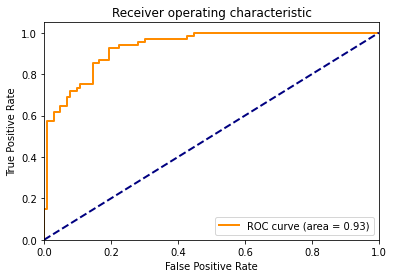

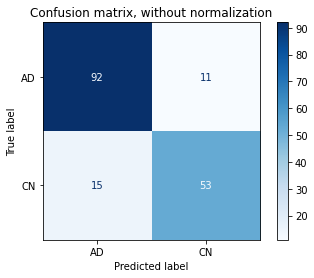

In [22]:
# Plot ROC curve
y_score = clf.predict_proba(array_test_select)
plot_roc_curve(y_score, labels_bin_test)

# Confusion matrix
disp = plot_confusion_matrix(clf_test, array_test_select, labels_bin_test,
                             display_labels=["AD", "CN"],
                             cmap=plt.cm.Blues,
                             normalize=None)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()